# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incompleteJCIJ62/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimension 64x64

In [3]:
sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 64, 64, 20)
0.0 1.0


Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [4]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]

Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

In [5]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,64,64,seqlen-1))
      batch_y = np.zeros((batchsize,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,:,:,random_start:random_end]
          batch_y[i] = minibatch[i,:,:,random_end:random_end+1]
          #print(batch_x.shape,batch_y.shape)
          #print(batch_x.min(),batch_x.max())
          #print(batch_x.min(),batch_x.max())
      yield(batch_x,batch_y)

In [ ]:
#prova_gen = image_generator(testset,batchsize=16,seqlen=4)

In [ ]:
#sample_x, sample_y = next(prova_gen)

In [ ]:
#print(type(sample_x))

<class 'numpy.ndarray'>


In [6]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

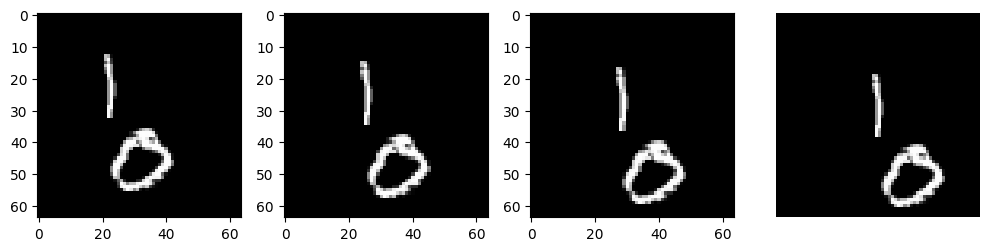

In [ ]:
#all = [sample_x[0,:,:,i] for i in range(3)]+[sample_y[0,:,:,0]]
#show_list(all)

In [ ]:
#train_gen = image_generator(trainset)
#val_gen = image_generator(valset)
#test_gen = image_generator(valset)

In [ ]:
#sample_x, sample_y = next(train_gen)

Disclaimer: The training has been carried out on Colab, using V100 GPU with 16GB ram.

### VisualKeras

Download visual-keras lib for better visualizations of the model.

In [7]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 35.7 MB/s eta 0:00:00


## Model definition and specs

In this section I define the model that will take out the task of predicting the next frame in a short movie sequence.</br></br>
The model can be defined as a <b>Convolutional Autoencoder</b>, which produces a latent representation of the three input frames (<i>considered as 3 channels of the same image</i>) and then decodes it to produce the output frame. Even though the model is an autoencoder, it is not trained to reconstruct the input frames, but to predict the next one.</br>
And, even if a model made up of convolutional LSTM layers could be more suited for the task, I found better performances with the autoencoder. This is due, in my opinion, to the length of the sequence, which is really short, thus not needing for a model to take into account the temporal dependecies of the frames. Additionally, seen that the input sequences of three frames are pretty similar, without big changes in the position of the digits, the model can learn to predict the next frame by just looking at the input ones, without the need of recurrent operations.

The optimizer used is <b>AdamW</b>, with a starting learning rate of <b>0.001</b> and a slightly modified weight decay of <b>1e-5</b>. The loss function is <b>Mean Squared Error</b>, which is the metric used to evaluate the model.

For what concerns the activation functions, I have experimented with different possibilities, and the mirrored combination of <b>Swish-Selu-Selu</b> is the one that gave me the best results. I have also tried to use the <b>LeakyReLU</b> activation function, which was blocking the model around mse=0,0078, thus resulting in poorer performances.

Finally, I have tried many times to reduce some additional regularizations to the model, such as the dropout and the L2, but the results were always worse than the ones obtained with the current configuration.

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization, ReLU
from tensorflow.keras.activations import swish, selu
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2

# Define the optimizer
optimizer = AdamW(learning_rate=0.001, weight_decay=0.005)

# Define the L2 regularization factor
#l2_reg = 0.0001

# Define the input shape
input_shape = (64, 64, 3)  # height, width, channels (sequence length)

# Define the input layer
inputs = Input(input_shape)

# Encoder Part
x = Conv2D(1024, (3, 3), padding='same')(inputs)
x = swish(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(512, (3, 3), padding='same')(x)
x = selu(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = selu(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder Part
x = Conv2D(256, (3, 3), padding='same')(encoded)
x = selu(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(512, (3, 3), padding='same')(x)
x = selu(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(1024, (3, 3), padding='same')(x)
x = swish(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Build and compile the model
conv_autoencoder = Model(inputs, outputs)
conv_autoencoder.compile(loss='mse', optimizer=optimizer)

# Print the model summary
conv_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 1024)      28672     
                                                                 
 tf.nn.silu_4 (TFOpLambda)   (None, 64, 64, 1024)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 1024)     4096      
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 1024)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 512)       4719

In [9]:
!mkdir conv_autoencoder

Below, you can see a visualization of the model, made with the visual-keras library.

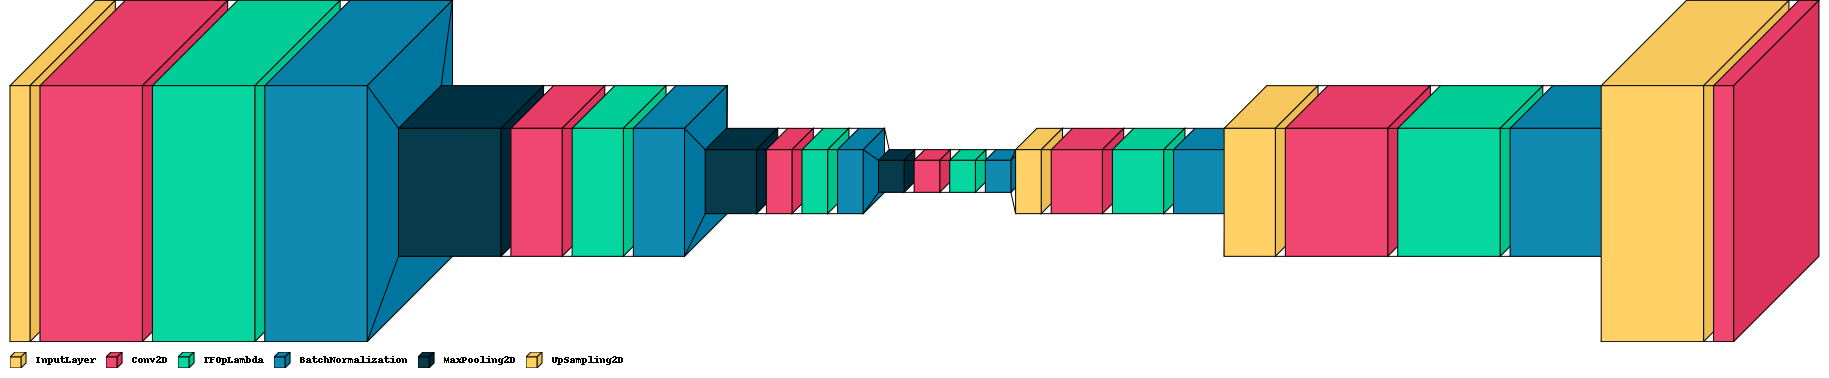

In [10]:
import visualkeras

visualkeras.layered_view(conv_autoencoder, legend=True, to_file='conv_autoencoder/conv_autoencoder.png').show()

### Training and Callback strategies

I have defined two callbacks for the training of the current model. The first one is the <b>ReduceLROnPlateau</b>, which reduces the learning rate by a factor of 0.5 if the validation loss does not improve for 8 epochs, adding also 6 epochs of cooldown after the reduction. The second one is the <b>EarlyStopping</b>, which stops the training if the validation loss does not improve for 15 epochs, and restores the best weight configuration of the model based on its capabilities of generalizing on the validation set.

In [11]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="auto", patience = 15,
                                        restore_best_weights = True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                        patience=8, cooldown=6, min_lr=0.0000001)

The effective training has been carried out with batch=16, for 150 epochs, even though the EarlyStopping callback stopped the training after 126 epochs, due to the fact that the validation loss did not improve for 15 epochs. The batch size of the validation set has been set to 32, while the one of the test set has been set, as default value, to 16.

In [17]:
batch_size = 16
epochs = 150

train_gen = image_generator(trainset, batch_size, 4)
val_gen = image_generator(valset, batch_size*2, 4)
test_gen = image_generator(testset)

steps_per_epoch = len(trainset)//batch_size
validation_steps = len(valset)//batch_size*2

history = conv_autoencoder.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    shuffle=True,
                    callbacks = [reduce_lr, earlystopping])

Epoch 1/150
500/500 [==============================] - 22s 35ms/step - loss: 0.0460 - val_loss: 0.0367 - lr: 0.0010
Epoch 2/150
500/500 [==============================] - 17s 34ms/step - loss: 0.0226 - val_loss: 0.0198 - lr: 0.0010
Epoch 3/150
500/500 [==============================] - 17s 34ms/step - loss: 0.0176 - val_loss: 0.0170 - lr: 0.0010
Epoch 4/150
500/500 [==============================] - 17s 34ms/step - loss: 0.0161 - val_loss: 0.0153 - lr: 0.0010
Epoch 5/150
500/500 [==============================] - 17s 34ms/step - loss: 0.0153 - val_loss: 0.0144 - lr: 0.0010
Epoch 6/150
500/500 [==============================] - 17s 34ms/step - loss: 0.0144 - val_loss: 0.0141 - lr: 0.0010
Epoch 7/150
500/500 [==============================] - 17s 34ms/step - loss: 0.0136 - val_loss: 0.0135 - lr: 0.0010
Epoch 8/150
500/500 [==============================] - 17s 34ms/step - loss: 0.0130 - val_loss: 0.0145 - lr: 0.0010
Epoch 9/150
500/500 [==============================] - 17s 34ms/step - l

Here, I plot on screen the trainin history stored and saved during the training of the model.

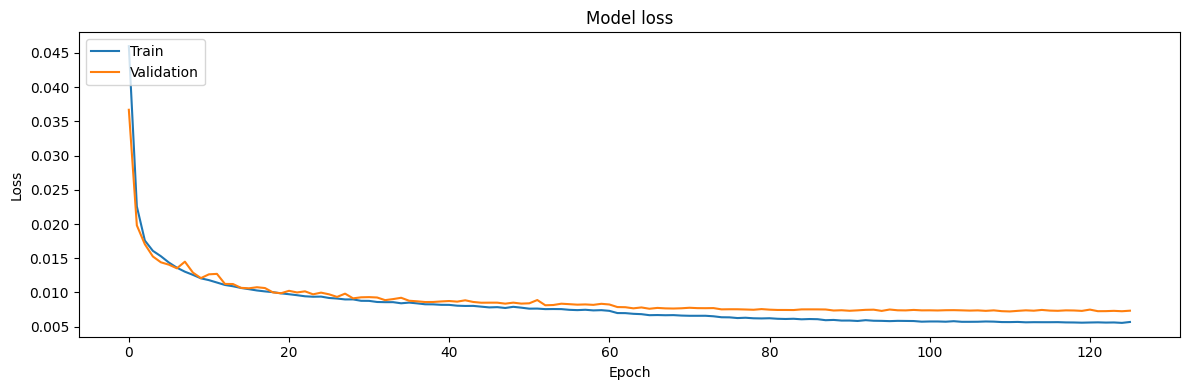

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Evaluation and final considerations

Below you can see the evaluation of the model, based on MSE, on the test set. The model gives results inline with the generalization results on the validation set, producing a final score of <b>0.0073</b> on the test set.

In [19]:
# Evaluate the model
test_steps = len(testset)//16
loss = conv_autoencoder.evaluate(test_gen, steps=test_steps)
print("Test Loss: ", loss)

62/62 [==============================] - 2s 11ms/step - loss: 0.0073
Test Loss:  0.007328885607421398


Below I saved the model and its weights, available upon request. 

In [20]:
conv_autoencoder.save('conv_autoencoder/model')
conv_autoencoder.save_weights('conv_autoencoder/weights')

In [21]:
!zip -r conv_autoencoder_bigger.zip /content/conv_autoencoder

  adding: content/conv_autoencoder/ (stored 0%)
  adding: content/conv_autoencoder/weights.data-00000-of-00001 (deflated 6%)
  adding: content/conv_autoencoder/conv_autoencoder.png (deflated 14%)
  adding: content/conv_autoencoder/checkpoint (deflated 37%)
  adding: content/conv_autoencoder/model/ (stored 0%)
  adding: content/conv_autoencoder/model/fingerprint.pb (stored 0%)
  adding: content/conv_autoencoder/model/assets/ (stored 0%)
  adding: content/conv_autoencoder/model/keras_metadata.pb (deflated 94%)
  adding: content/conv_autoencoder/model/variables/ (stored 0%)
  adding: content/conv_autoencoder/model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/conv_autoencoder/model/variables/variables.index (deflated 73%)
  adding: content/conv_autoencoder/model/saved_model.pb (deflated 90%)
  adding: content/conv_autoencoder/weights.index (deflated 73%)


Finally, I have plotted the predictions of the model on a batch of the test set, in order to have a visual idea of the quality of the predictions. As you can see, the model is able to predict the next frame with pretty good quality and precision.

Below, you will see as first three elements, the sequence given in input, as fourth element the actual frame aimed to be predicted, and as fifth element the frame that the model has predicted.

1/1 [==============================] - 0s 22ms/step


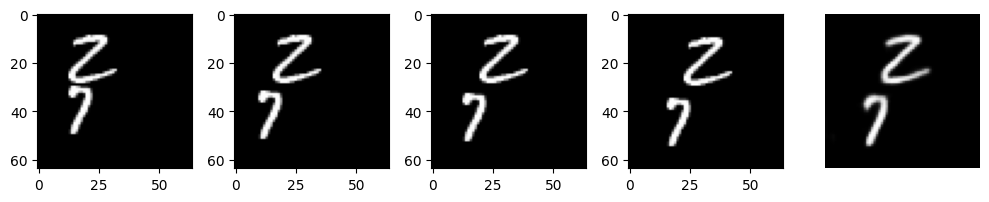

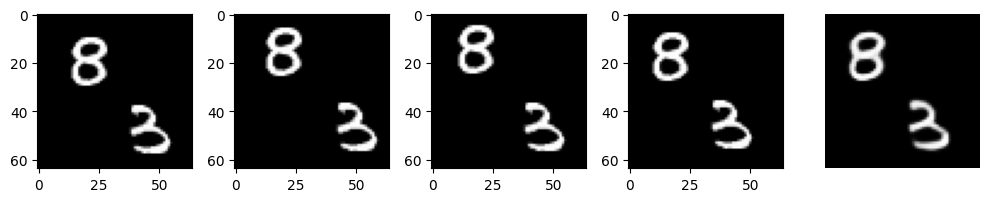

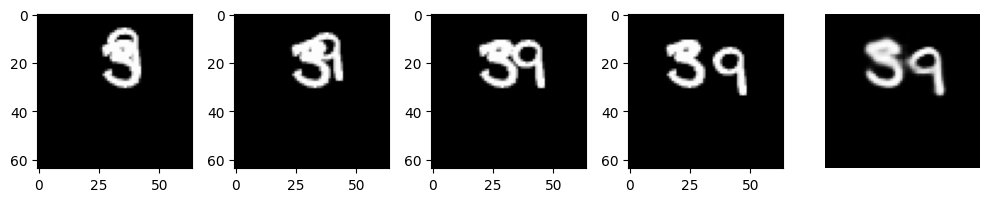

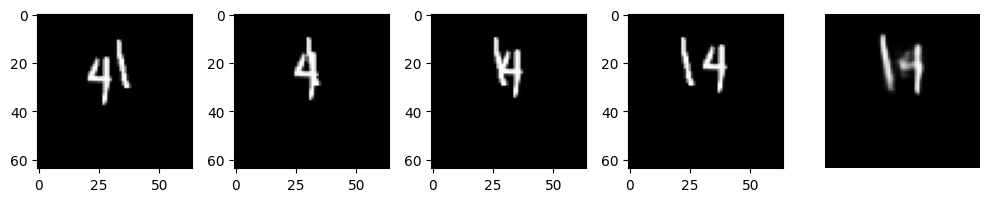

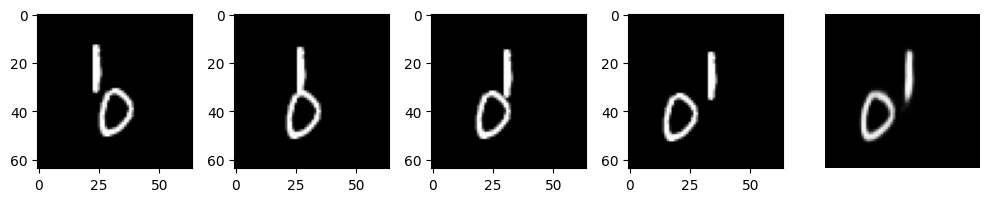

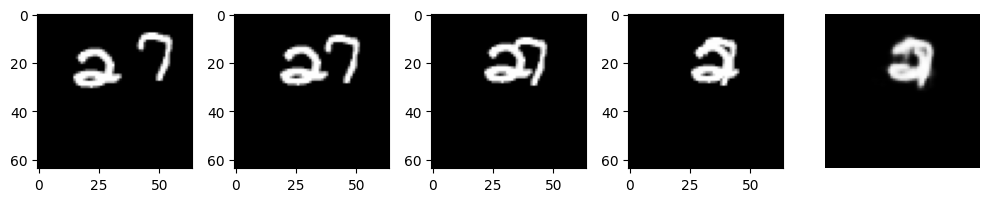

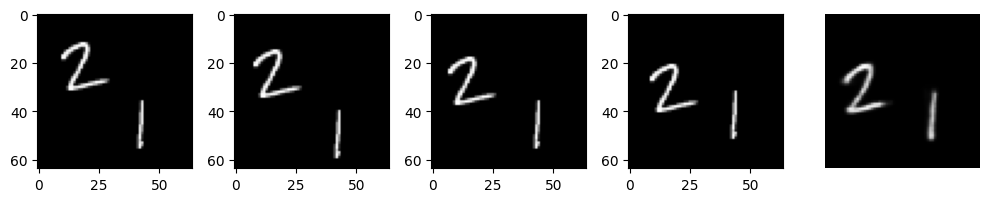

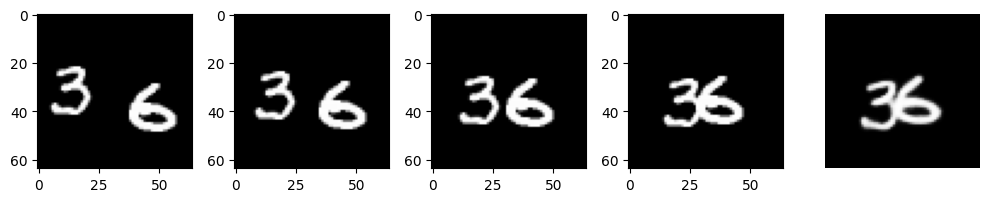

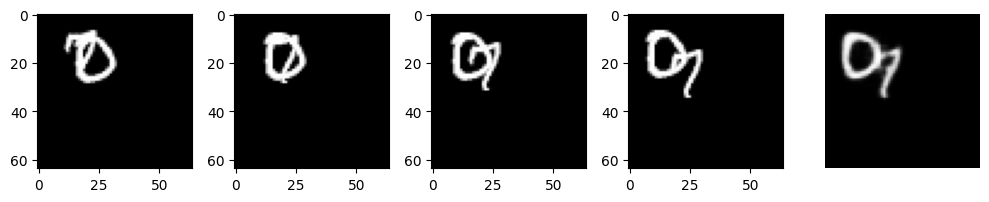

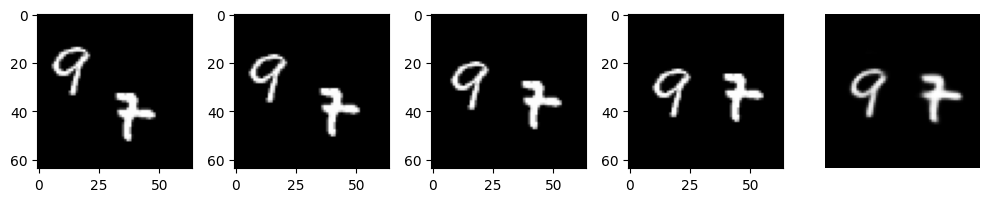

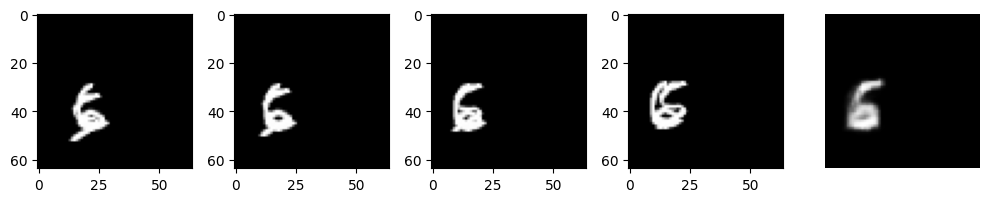

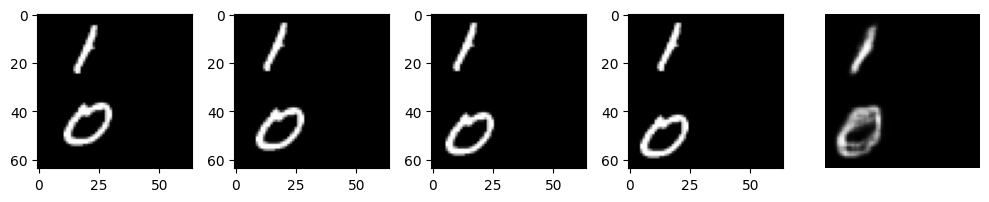

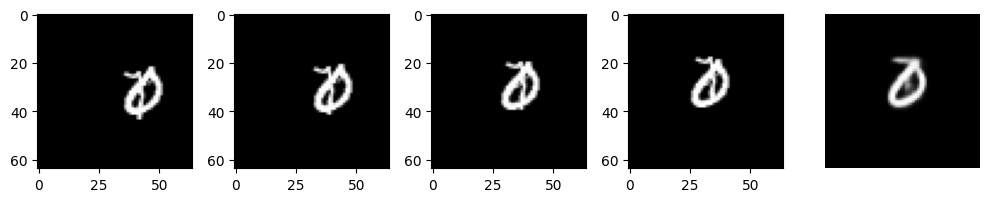

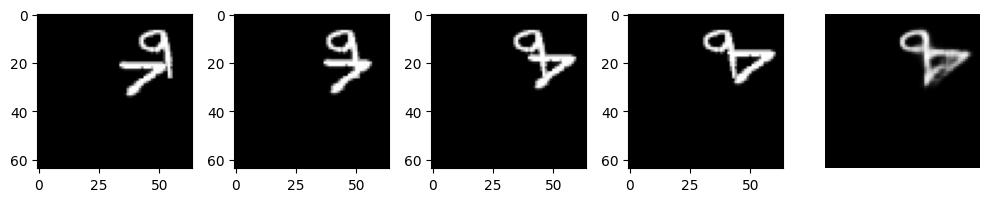

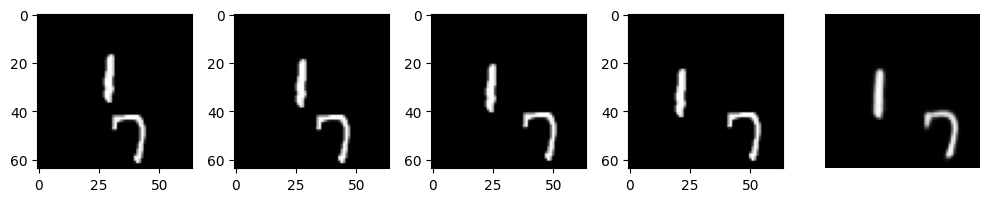

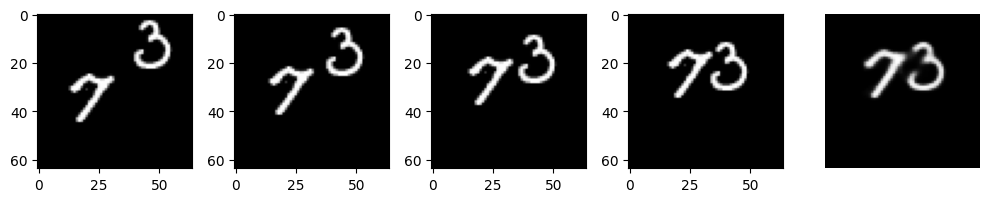

In [25]:
test_images, test_labels = next(test_gen)
predicted_images = conv_autoencoder.predict(test_images)

for i in range(16):
    original_images = test_images[i]
    target_image = test_labels[i]
    predicted_image = predicted_images[i]

    # Cast to integer (255px)
    original_images = (original_images * 255).astype(np.uint8)
    target_image = (target_image * 255).astype(np.uint8)
    predicted_image = (predicted_image * 255).astype(np.uint8)

    target_image = np.squeeze(target_image, axis=-1)
    predicted_image = np.squeeze(predicted_image, axis=-1)

    original_images = np.transpose(original_images, (2, 0, 1))
    show_list(original_images.tolist() + [target_image, predicted_image])
